# Tropomi Loading and Visualization 
This notebook is a first crack at loading and visualizing TROPOMI data. It is loosely based on https://fire.trainhub.eumetsat.int/docs/figure5_Sentinel-5P_TROPOMI_CO.html which uses useful functions from https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/blob/master/functions.ipynb. 

In [1]:
#Import relevant packages
import os
import xarray as xr
import numpy as np

# Python libraries for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import cartopy.io.img_tiles as cimgt


In [15]:
#Load a TROPOMI ch4 file from local
s5p_fname = '/Users/agmeyer4/LAIR_1/Data/TROPOMI/nc_files/S5P_OFFL_L2__CH4____20230708T201000_20230708T215129_29715_03_020500_20230710T121253.nc'
s5p = xr.load_dataset(s5p_fname,group ='PRODUCT') #loads the xarray of the "product" group where the ch4 data is stored

# Below loads the detailed results xarray. This ontains the column averaging kernel for cross validation with models/insitu/other instruments,
# but I haven't done anything with it yet. 
s5p_detres = xr.load_dataset(s5p_fname,group ='PRODUCT/SUPPORT_DATA/DETAILED_RESULTS') 


In [16]:
s5p_ch4 = s5p['methane_mixing_ratio'] #Subselect the methane mixing ratio variable
s5p_ch4_t0 = s5p_ch4.isel(time=0) #there's only one time in the dataarray, so just select the index 0

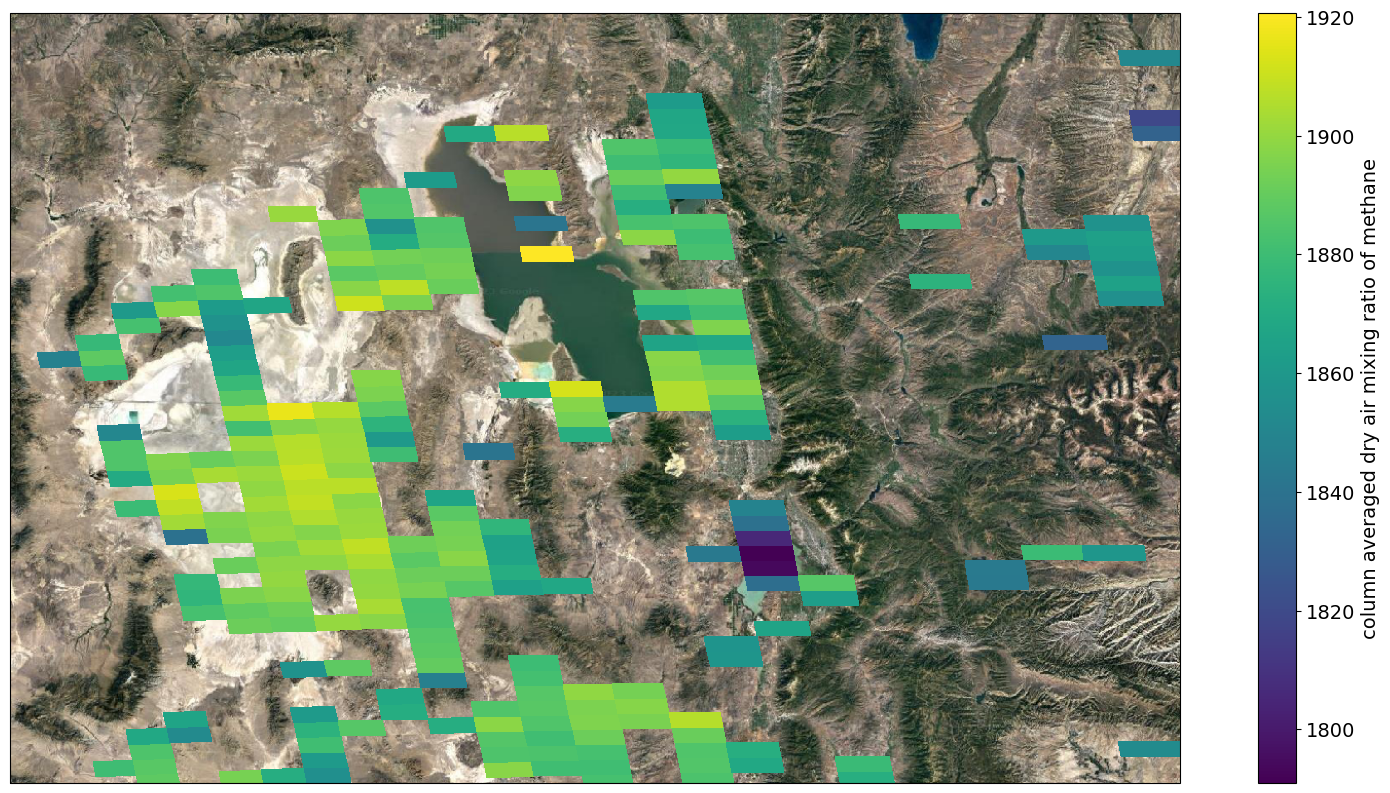

In [18]:
subset_extent=[-114.3,-110.5,39.5,42.0] #define a lat/lon extent box for plotting
map_extent=subset_extent #[-140.3,-90.5,-20.5,44.0]   #define the extent of the map 

#subselect within the lat/lon extent box
subset_for_plot = s5p_ch4_t0.where(
                        (s5p_ch4_t0['longitude']>subset_extent[0]) & (s5p_ch4_t0['longitude']<subset_extent[1]) &
                        (s5p_ch4_t0['latitude']>subset_extent[2]) & (s5p_ch4_t0['latitude']<subset_extent[3])
                        ) 

zoom = 1 #controls resolution of the map -- if really slow make this higher
labsize = 14 #labelsize
proj = ccrs.PlateCarree() #map projection
 
#Create the figure, set to size,
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=proj)
ax.set_extent(map_extent,crs=proj)
ax.coastlines()

#Add the background map, can comment this out if slow or not needed
request = cimgt.GoogleTiles(style='satellite')
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
ax.add_image(request,int(scale))

#plot the subset for the s5p data 
s5p_plot = ax.pcolormesh(subset_for_plot.longitude, subset_for_plot.latitude, subset_for_plot, 
                    cmap=plt.get_cmap('viridis'), transform=ccrs.PlateCarree(),
                    #vmin=vmin,
                    #vmax=vmax,
                    shading='auto')

cbar = plt.colorbar(s5p_plot,fraction=0.028)
cbar.ax.tick_params(labelsize=labsize)
cbar.set_label(label = s5p_ch4.long_name,size=labsize)

plt.show()
    
